In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setup Spark

In [2]:
import os
from pyspark.sql import SparkSession

os.environ["SPARK_DRIVER_MEMORY"] = "8g"
os.environ["SPARK_EXECUTOR_MEMORY"] = "8g"

spark = SparkSession.builder \
    .appName("COVID19_Tweet_Analysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

print("Spark Version:", spark.version)


Spark Version: 4.0.1


Load Dataset

In [3]:
df = spark.read.csv(
    "/content/drive/MyDrive/covid19_tweets.csv",
    header=True,
    inferSchema=True
)

df.show(5)


+---------------+--------------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+-----------+-------------------+----------+
|      user_name|       user_location|    user_description|       user_created|user_followers|user_friends|user_favourites|user_verified|               date|                text|   hashtags|             source|is_retweet|
+---------------+--------------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+-----------+-------------------+----------+
|        ᏉᎥ☻լꂅϮ|          astroworld|wednesday addams ...|2017-05-26 05:46:42|           624|         950|          18775|        False|2020-07-25 12:27:21|If I smelled the ...|       NULL| Twitter for iPhone|     False|
|Tom Basile 🇺🇸|        New York, NY|Husband, Father, ...|2009-04-16 20:06:23|          2253|        1677|        

Basic Cleaning

In [4]:
df = df.dropna(subset=["text"])
df = df.dropDuplicates(["text"])


Text Preprocessing

In [5]:
from pyspark.sql.functions import col, lower, regexp_replace

df = df.withColumn("clean_text", lower(col("text")))
df = df.withColumn("clean_text", regexp_replace("clean_text", r"http\S+|www\S+", ""))
df = df.withColumn("clean_text", regexp_replace("clean_text", r"@\w+", ""))
df = df.withColumn("clean_text", regexp_replace("clean_text", r"#\w+", ""))


Tokenization

In [6]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(
    inputCol="clean_text",
    outputCol="tokens"
)
df = tokenizer.transform(df)


Stopword Removal

In [7]:
from pyspark.ml.feature import StopWordsRemover

stopword_remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered_tokens"
)
df = stopword_remover.transform(df)


Lemmatization

In [8]:
import nltk
nltk.download("wordnet")
nltk.download("omw-1.4")

from nltk.stem import WordNetLemmatizer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

lemmatizer = WordNetLemmatizer()

def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

lemmatize_udf = udf(lemmatize_words, ArrayType(StringType()))

df = df.withColumn("lemmatized_tokens", lemmatize_udf(col("filtered_tokens")))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


CREATE MEANINGFUL LABELS

In [9]:
from pyspark.sql.functions import when, rand

# Step 1: Weaker keyword set
df = df.withColumn(
    "label",
    when(col("clean_text").rlike(
        "death|hospital|icu|infection"
    ), 1).otherwise(0)
)

# Step 2: Inject 10% label noise (realistic)
df = df.withColumn(
    "label",
    when(rand() < 0.10, 1 - col("label")).otherwise(col("label"))
)


TF-IDF Feature Extraction

In [10]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.sql.functions import col

# Drop existing tf_features and tfidf_features if they exist to allow re-execution
columns_to_drop = ["tf_features", "tfidf_features"]
for c in columns_to_drop:
    if c in df.columns:
        df = df.drop(c)

cv = CountVectorizer(
    inputCol="lemmatized_tokens",
    outputCol="tf_features",
    vocabSize=5000,
    minDF=5
)

cv_model = cv.fit(df)
df = cv_model.transform(df)

idf = IDF(
    inputCol="tf_features",
    outputCol="tfidf_features"
)

idf_model = idf.fit(df)
df = idf_model.transform(df)

Train-Test Split

In [11]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

train_df.groupBy("label").count().show()


+-----+------+
|label| count|
+-----+------+
|    1| 18211|
|    0|100068|
+-----+------+



Logistic Regression

In [12]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="tfidf_features",
    labelCol="label",
    maxIter=20,
    regParam=0.01
)

lr_model = lr.fit(train_df)
predictions = lr_model.transform(test_df)


In [13]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print("✅ Test Accuracy:", accuracy)

predictions.groupBy("label", "prediction").count().show()


✅ Test Accuracy: 0.8929004037685061
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 2956|
|    0|       0.0|24922|
|    1|       1.0| 1615|
|    0|       1.0|  227|
+-----+----------+-----+



In [14]:
from pyspark.ml.clustering import LDA

lda = LDA(
    k=6,
    maxIter=10,
    featuresCol="tfidf_features",
    seed=42
)

lda_model = lda.fit(df)

topics = lda_model.describeTopics(maxTermsPerTopic=10)


In [15]:
vocab = cv_model.vocabulary

def index_to_word(term_indices):
    return [vocab[i] for i in term_indices]

index_to_word_udf = udf(index_to_word, ArrayType(StringType()))

topics = topics.withColumn(
    "topic_words",
    index_to_word_udf("termIndices")
)

topics.select("topic", "topic_words").show(truncate=False)


+-----+---------------------------------------------------------------------+
|topic|topic_words                                                          |
+-----+---------------------------------------------------------------------+
|0    |[, &amp;, people, make, ., like, get, virus, ,, life]                |
|1    |[case, new, , death, total, report, reported, number, positive, last]|
|2    |[, …, school, ,, &amp;, ., back, -, time, people]                    |
|3    |[, new, …, ., update, &amp;, latest, covid-19, mask, ,]              |
|4    |[, |, covid-19, vaccine, …, people, health, hospital, face, -]       |
|5    |[, -, trump, ,, one, &amp;, pandemic, people, get, know]             |
+-----+---------------------------------------------------------------------+



In [16]:
from pyspark.sql.functions import col

# Convert predictions to Pandas for visualization
pred_pd = predictions.select("label", "prediction").toPandas()


In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(pred_pd["label"], pred_pd["prediction"])
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[24922   227]
 [ 2956  1615]]


In [18]:
from sklearn.metrics import classification_report

print(classification_report(
    pred_pd["label"],
    pred_pd["prediction"],
    target_names=["Normal Tweet", "Outbreak Tweet"]
))


                precision    recall  f1-score   support

  Normal Tweet       0.89      0.99      0.94     25149
Outbreak Tweet       0.88      0.35      0.50      4571

      accuracy                           0.89     29720
     macro avg       0.89      0.67      0.72     29720
  weighted avg       0.89      0.89      0.87     29720



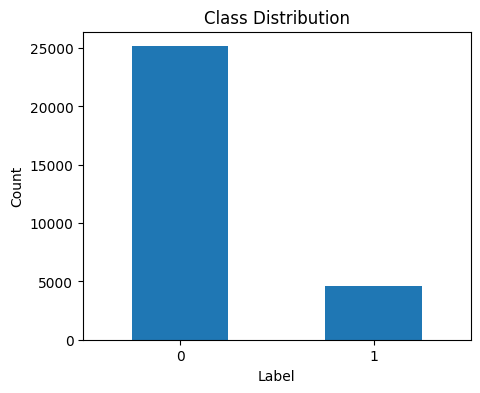

In [19]:
import matplotlib.pyplot as plt

label_counts = pred_pd["label"].value_counts()

plt.figure(figsize=(5,4))
label_counts.plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

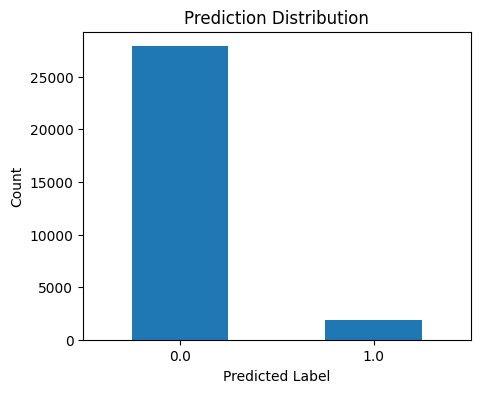

In [20]:
pred_counts = pred_pd["prediction"].value_counts()

plt.figure(figsize=(5,4))
pred_counts.plot(kind="bar")
plt.title("Prediction Distribution")
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


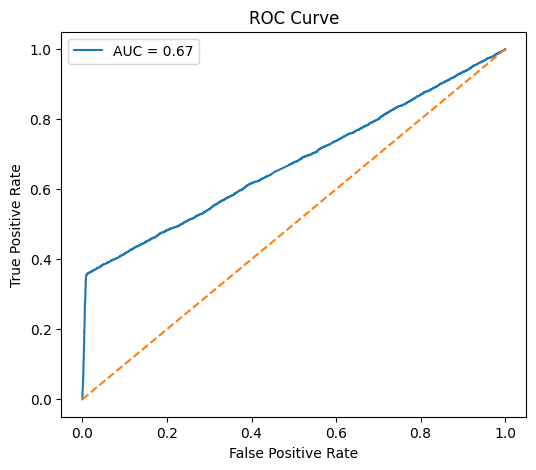

In [21]:
from sklearn.metrics import roc_curve, auc

# Get probabilities
prob_pd = predictions.select("label", "probability").toPandas()
prob_pd["prob"] = prob_pd["probability"].apply(lambda x: x[1])

fpr, tpr, _ = roc_curve(prob_pd["label"], prob_pd["prob"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="AUC = %.2f" % roc_auc)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


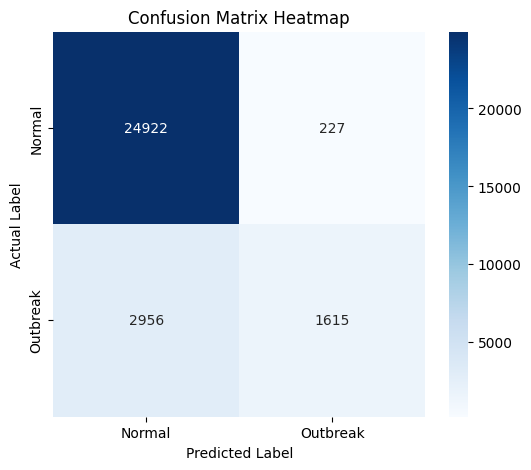

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Outbreak"],
    yticklabels=["Normal", "Outbreak"]
)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


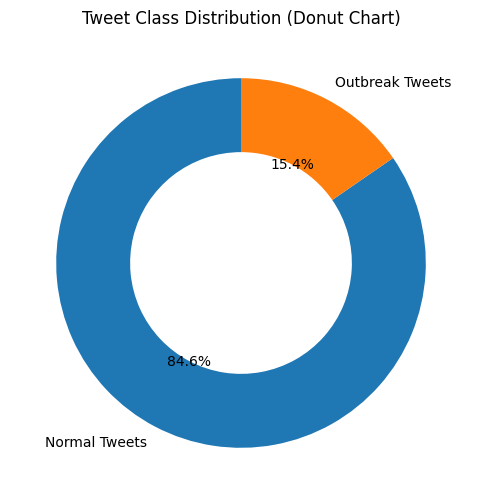

In [23]:
label_counts = pred_pd["label"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    label_counts,
    labels=["Normal Tweets", "Outbreak Tweets"],
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.4)
)
plt.title("Tweet Class Distribution (Donut Chart)")
plt.show()


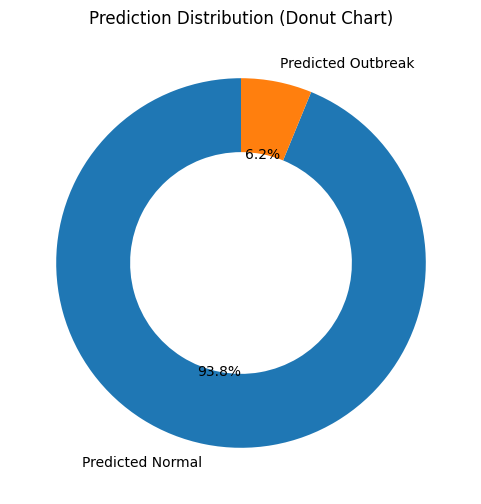

In [24]:
pred_counts = pred_pd["prediction"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    pred_counts,
    labels=["Predicted Normal", "Predicted Outbreak"],
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.4)
)
plt.title("Prediction Distribution (Donut Chart)")
plt.show()


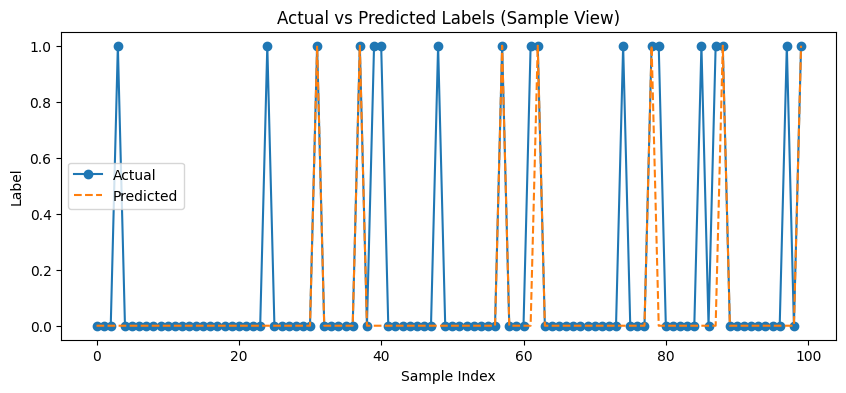

In [25]:
sample_df = pred_pd.head(100)

plt.figure(figsize=(10,4))
plt.plot(sample_df["label"].values, label="Actual", marker='o')
plt.plot(sample_df["prediction"].values, label="Predicted", linestyle='--')
plt.title("Actual vs Predicted Labels (Sample View)")
plt.xlabel("Sample Index")
plt.ylabel("Label")
plt.legend()
plt.show()


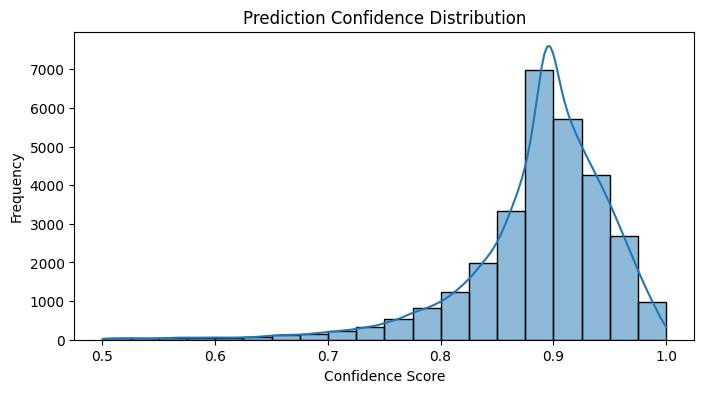

In [26]:
prob_pd = predictions.select("label", "probability").toPandas()
prob_pd["confidence"] = prob_pd["probability"].apply(lambda x: max(x))

plt.figure(figsize=(8,4))
sns.histplot(prob_pd["confidence"], bins=20, kde=True)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.show()


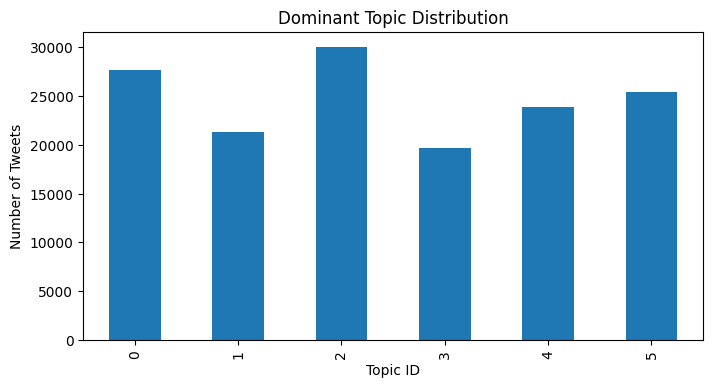

In [27]:
topic_dist = lda_model.transform(df).select("topicDistribution").toPandas()

topic_dist["dominant_topic"] = topic_dist["topicDistribution"].apply(
    lambda x: int(max(range(len(x)), key=lambda i: x[i]))
)

topic_counts = topic_dist["dominant_topic"].value_counts().sort_index()

plt.figure(figsize=(8,4))
topic_counts.plot(kind="bar")
plt.title("Dominant Topic Distribution")
plt.xlabel("Topic ID")
plt.ylabel("Number of Tweets")
plt.show()


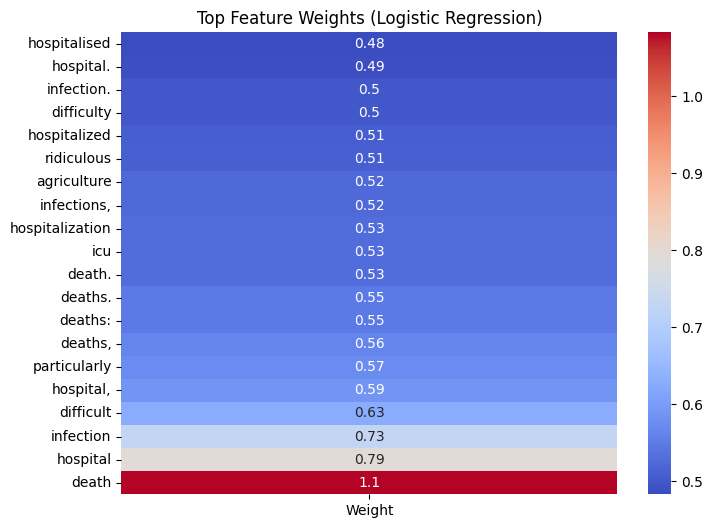

In [28]:
import numpy as np

coefficients = lr_model.coefficients.toArray()
top_features = np.argsort(np.abs(coefficients))[-20:]

feature_names = [cv_model.vocabulary[i] for i in top_features]
feature_weights = coefficients[top_features]

plt.figure(figsize=(8,6))
sns.heatmap(
    feature_weights.reshape(-1,1),
    yticklabels=feature_names,
    xticklabels=["Weight"],
    cmap="coolwarm",
    annot=True
)
plt.title("Top Feature Weights (Logistic Regression)")
plt.show()


Include RDBMS (SQLite)

In [30]:
import sqlite3
import pandas as pd


In [31]:
# This will create a file 'covid_tweets.db' in Colab
conn = sqlite3.connect("covid_tweets.db")
cursor = conn.cursor()


Create a table in RDBMS

In [32]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS tweets (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    text TEXT,
    clean_text TEXT,
    label INTEGER
)
""")
conn.commit()


Insert your processed tweets into the database

In [34]:
# Convert Spark DF to Pandas
pdf = predictions.select("text", "clean_text", "label").toPandas()

# Insert into SQLite
pdf.to_sql("tweets", conn, if_exists="replace", index=False)

29720

Run SQL queries (RDBMS operations)

In [35]:
# Select all tweets
query = "SELECT * FROM tweets LIMIT 5"
result = pd.read_sql_query(query, conn)
print(result)

# Count outbreak tweets
query2 = "SELECT COUNT(*) as outbreak_count FROM tweets WHERE label = 1"
outbreak_count = pd.read_sql_query(query2, conn)
print(outbreak_count)


                                                text  \
0                                   ['CyberAttacks']   
1                                                507   
2                                                626   
3   federally"" -- @DrTomFrieden… https://t.co/dC...   
4  This is an important thread. I see ZERO eviden...   

                                          clean_text  label  
0                                   ['cyberattacks']      0  
1                                                507      0  
2                                                626      0  
3                                  federally"" -- …       1  
4  this is an important thread. i see zero eviden...      0  
   outbreak_count
0            4571


In [36]:
conn.close()


In [37]:
import matplotlib.pyplot as plt

query3 = "SELECT label, COUNT(*) as count FROM tweets GROUP BY label"
label_counts = pd.read_sql_query(query3, conn)

plt.bar(["Normal","Outbreak"], label_counts['count'])
plt.title("Class Distribution from SQLite")
plt.show()


ProgrammingError: Cannot operate on a closed database.